#  Lab 10: Example of use of Bayesian optimization algorithms on an aerospace vehicle design 

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import HTML, display
from IPython.display import Image

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#Gaussian process library
#!pip install GPy
import GPy

# Install PyDoE package for design of experiment
#!pip install pyDOE2
from pyDOE2 import lhs

from scipy.stats import norm
import scipy
import time
import copy

In this Lab, we optimize the design on solid propellant booster (see Lab 3) with Bayesian optimization.



## <font color='blue'> Problem description</font>

- <font color='blue'> Analysis </font> of a **solid propellant booster performance** using four coupled disciplines:
    - Propulsion,
    - Structure,
    - Mass estimation,
    - Performance analyses.    
    

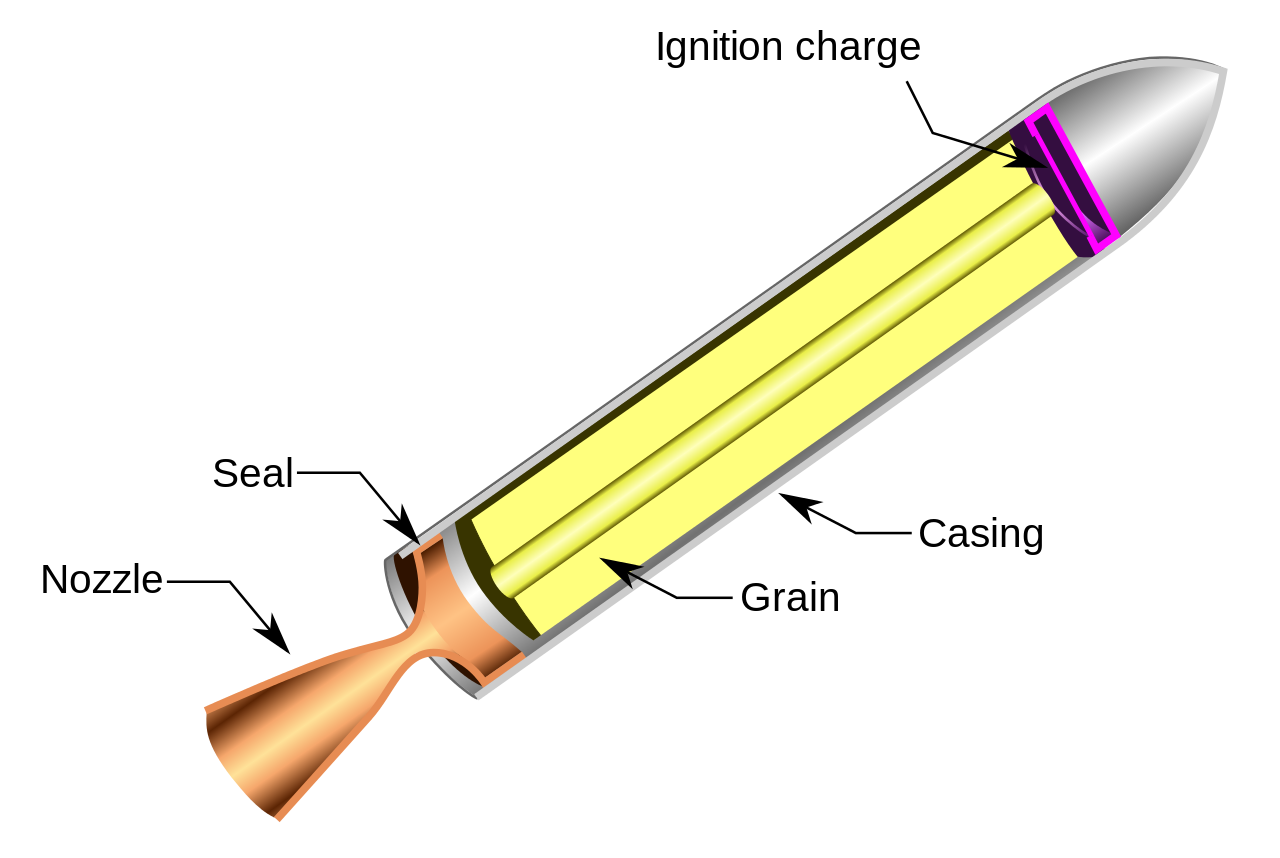

In [2]:
Image("fusee.png",width = 400, height = 300)

Instead of performing the multiobjective optimization of the booster as performed in Lab 3, we aim at optimizing the design of a solid propellant rocket booster for one only objective :
- Maximization of the increment of velocity of the booster

The second objective (GLOW of the booster) is taken as constraint.

Four optimization variables are involved : 
- Diameter of the nozzle throat ($Dc$)
- Exit diameter of the nozzle ($Ds$)
- Combustion pressure ($Pc$)
- Mass of propellant ($M$)

The bounds of the design  variables are the following: 
  - $0.05 \leq Dc \leq  1$ (in meters)
  - $0.5 \leq  Ds \leq  1.2$ (in meters)
  - $1 \leq  Pc \leq  500$ (in bars)
  - $10000. \leq  M \leq  15000.$ (in kg)
  
  
We suppose that the booster has a payload of 500 kg.

Eight constraints are involved in the design optimization problem relative to the propulsion and the structural sizing: 
- Consistency of combustion pressure with respect to the ambient pressure
- Consistency between the nozzle exit diameter and the throat diameter
- Consistency between the nozzle exit pressure and the combustion pressure
- Constraint of characteristic velocity of propellant
- Consistency of the propellant filling 
- Consistency of the clamping
- Two bulk constraints on the solid booster
- GLOW has to be less than 12 t (additional constraint w.r.t. Lab 3)

## Design process : 

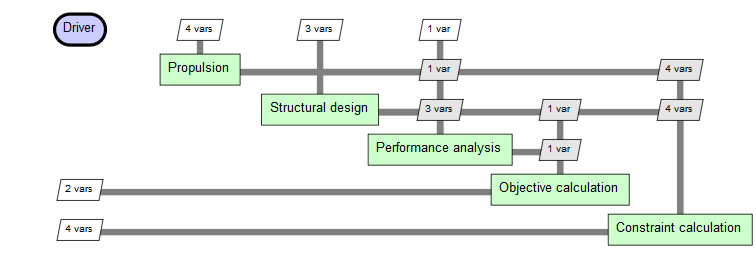

In [3]:
Image("xdsm_booster.png",width = 800, height = 400)

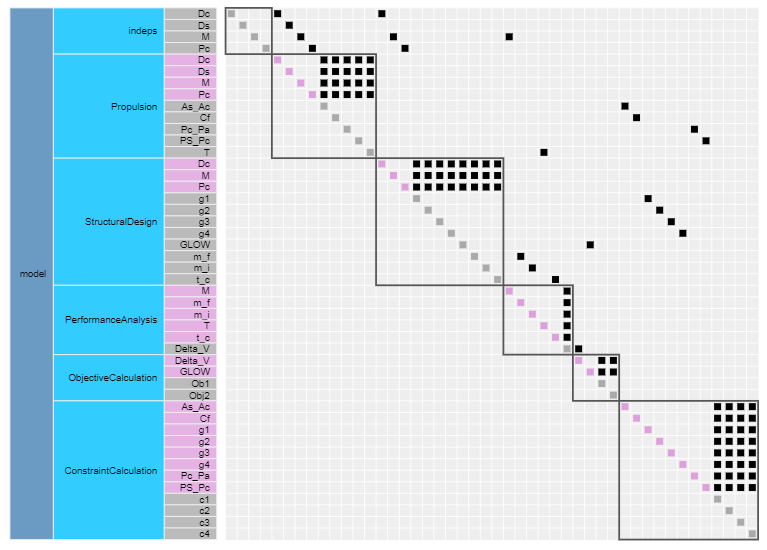

In [4]:
Image("partition_tree_n2.png",width = 700, height = 500)

## <font color='blue'> Problem simulation</font>
Import of general python librairy 

In [5]:
import Masse, Propulsion, MDA #python functions required to run the simulations

# Usage : [Obj, Cons] = MDA(X)

All the design variables have been normalized between 0. and 1.

In [6]:
MDA.Booster(np.array([1.,1.,1.,1.]))

(-3.5891803911715563,
 array([-0.9948494 , -0.00971429, -0.69493707, -0.68322634,  0.12175233,
         1.39709532, -0.04838154,  0.01504821,  0.55779153]))

Here, the simulation code provides both objective function and constraints in a same function, so we ave to modify a little bit the EGO optimization scheme

In [7]:
def fct_booster(x):
    f = np.zeros((len(x),1))
    g = np.zeros((len(x),9))
    
    for i in range(len(x)):
        f[i],g[i]= MDA.Booster(x[i])
    return f,g.T

In [8]:
# The EGO algorithm takes as arguments :
# f :the simulation function that computes the objective function and the constraints,
# bounds : the bounds on the design variable
# k_obj_ref, k_cons_ref : kernel on objective function and list of kernels on constraints function
# DoE : normalized DoE (on [0,1]x R^d)
# acquisition_function : acquisition function
# num_iter : the maximal number of iterations
# threshold_EI : the threshold criterion on EI

# The EGO returns :
# List of evaluated points 
# List of new points along the iterations
# List of best current points
def EGO(f_obj,bounds,\
        k_obj_ref,\
        k_cons_ref,\
        DoE,\
        acquisition_function,\
        num_iter = 50,\
        threshold_EI=1e-6):
    
    current_DoE =DoE
    current_obj_non_norm,current_cons = f_obj(current_DoE*(bounds[:,1]-bounds[:,0])+bounds[:,0])
    
    mean_obj = current_obj_non_norm.mean()
    std_obj = current_obj_non_norm.std()
    current_obj = (current_obj_non_norm-mean_obj)/std_obj
    #current_min = np.min(current_obj)
    # Evaluation of constraints and definition of feasible points
    x_feasible= []
    y_feasible = []
    
    
    #current_cons.append(constraints(DoE*(bounds[:,1]-bounds[:,0])+bounds[:,0]))
        
    #current_cons = np.array(current_cons)
    for i in range(len(DoE)):
        if np.max(current_cons[:,i],axis = 0)<0:
            x_feasible.append(DoE[i])
            y_feasible.append(current_obj[i])
            current_min = np.min(y_feasible)
    if len(y_feasible)==0:
        current_min = np.max(current_obj)
            
    ###Print of results
    print("iteration|         current |        best |   infill x PF | max g | elapsed time")
    print("------------------------------------------------------------------------------------------")
    iter_ = 0
    EI_ = 50
    t0 = time.time()
    best = []
    while iter_ < num_iter and EI_ > threshold_EI:#for i in range():
        k = copy.deepcopy(k_obj_ref)
        m_obj = GPy.models.GPRegression(current_DoE,current_obj,k)
        m_obj.likelihood.variance = 1e-10
        m_obj.likelihood.variance.fix()
        m_obj.optimize()
            
        gp_cons = []
        iter_cons = 0
        k_cons =copy.deepcopy(k_cons_ref)
        for k_cons_ in k_cons:
            
            gp_cons.append(GPy.models.GPRegression(current_DoE,np.array(current_cons[iter_cons]).reshape(len(current_cons[iter_cons]),1),k_cons[iter_cons]))
            gp_cons[-1].likelihood.variance = 1e-10
            gp_cons[-1].likelihood.variance.fix()
            gp_cons[-1].optimize()
            iter_cons +=1
        x_new,EIxPF,EI_ = optim_infill(m_obj,gp_cons,bounds,current_min,acquisition_function,seed=0)
        
        
        #Adding new point to the dataset
        f_new,cons_new = f_obj(np.array([x_new])*(bounds[:,1]-bounds[:,0])+bounds[:,0])
        y_new = f_new
        
        current_DoE = np.append(current_DoE,np.array([x_new]),axis = 0)
        current_obj = np.append(current_obj,(y_new-mean_obj)/std_obj,axis = 0)
        
        new_cons = []
            
        new_cons.append(cons_new)
    
        current_cons =  np.concatenate((current_cons,cons_new),axis = 1)
               
        # Calculation of new current min if feasible constraints
        if np.max(new_cons)<=0:
            y_feasible.append((y_new-mean_obj)/std_obj)
            current_min = np.min(y_feasible)
        print("%9.d|%17.4e|%13.04f|%13.04f|%6.04f|%6.04f" %(iter_, y_new, std_obj*current_min+mean_obj,EIxPF,np.max(new_cons),time.time()-t0))    
        best.append(std_obj*current_min+mean_obj)
        iter_ +=1
        
    return current_DoE*(bounds[:,1]-bounds[:,0])+bounds[:,0],std_obj*current_obj+mean_obj,best

In [9]:
#Definition of acquisition function

#Here we implement EI x PF which calls EI and PF functions
# This function requires as arguments: 
# - the point to evaluate
# - the surrogate model of objective function
# - the list of surrogate models of constraints functions
# - the current minimum

def EIxPF(x,m_obj,m_cons,y_min):
    
    return  EI(x,m_obj,y_min) * PF(x,m_cons)

def EI(x,gp,y_min):
    pred,var = gp.predict(np.array([x]))
    var = np.max([1e-15,var])
    std = np.sqrt(var)
    EI = (y_min-pred)* norm.cdf((y_min-pred)/std)+std*norm.pdf((y_min-pred)/std)
    if np.isnan(EI[0][0]):
        EI[0][0] = 0.
    return -EI[0][0]

def PF(x,gps):
    PF = 1.
    for gp in gps:
        pred,var = gp.predict(np.array([x]))    
        var = np.max([1e-15,var])
        std = np.sqrt(var)
        PF = PF* norm.cdf(-pred/std)     
    return PF[0][0]

In [10]:
# This function is used to optimize the infill criterion, it takes as arguments :
# m_obj : the GP of the objective function
# y_min : the current minimum
# seed : the seed of the stochastic optimization algorithm

# It returns the location of the best point to infill as well as the optimized value of EI

# Here, the Differential Evolution (See Lecture 1) is used as the EI present a lot of local minima

def optim_infill(m_obj,m_cons,bounds,y_min,acquisition_function,seed):
    f = lambda x : acquisition_function(x,m_obj,m_cons,y_min)
    bounds_norm = bounds
    np.random.seed(seed)
    struct_res = scipy.optimize.differential_evolution(f,\
                                                    popsize=20,
                                                    maxiter =20,
                                                    bounds = bounds_norm)
    
    x_opt_de = struct_res.x
    res_de = struct_res.fun
    EI_ = - EI(x_opt_de,m_obj,y_min)
    return x_opt_de,np.abs(res_de),EI_

## Exercice :
Here we set the GLOW to be less than 12t. Try to find the corresponding optimal $\Delta_V$ and compare with the Pareto Front obtained in Lab 3.


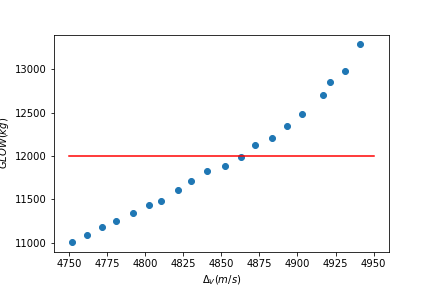

In [11]:
Image("Pareto_front.png",width = 400, height = 300)